# INT8 Quantization with Post-training Optimization Tool (POT) in Simplified Mode tutorial
This tutorial was adapted from https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/114-quantization-simplified-mode. Here, we use OpenVINO APIs provided by BigDL Nano instead to simplify the original tutorial.

This tutorial shows how to quantize a [ResNet20](https://github.com/chenyaofo/pytorch-cifar-models) image classification model, trained on [CIFAR10 ](http://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) dataset, using the Simplified Mode of OpenVINO Post-Training Optimization Tool (POT).

Simplified Mode is designed to make the data preparation step easier, before model optimization. The mode is represented by an implementation of the engine interface in the POT API. It enables reading data from an arbitrary folder specified by the user. Currently, Simplified Mode is available only for image data in PNG or JPEG formats, stored in a single folder.

**Note:** This mode cannot be used with the accuracy-aware method. It is not possible to control accuracy after optimization using this mode. However, Simplified Mode can be useful for estimating performance improvements when optimizing models.

This tutorial includes the following steps:

- Downloading and saving the CIFAR10 dataset
- Preparing the model for quantization
- Compressing the prepared model
- Measuring and comparing the performance of the original and quantized models
- Demonstrating the use of the quantized model for image classification


In [1]:
import os
from pathlib import Path
import warnings

import torch
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import numpy as np

from bigdl.nano.pytorch import Trainer
from torch.utils.data.dataloader import DataLoader

warnings.filterwarnings("ignore")

# Set the data and model directories
MODEL_DIR = 'model'
CALIB_DIR = 'calib'
CIFAR_DIR = 'cifar'
CALIB_SET_SIZE = 300
MODEL_NAME = 'resnet20'

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CALIB_DIR, exist_ok=True)

## Prepare the calibration dataset
The following steps are required to prepare the calibration dataset:
- Download CIFAR10 dataset from Torchvision.datasets repository
- Save the selected number of elements from this dataset as .png images in a separate folder

In [2]:
transform = T.Compose([T.ToTensor()])
dataset = CIFAR10(root=CIFAR_DIR, train=False, transform=transform, download=True)

Files already downloaded and verified


## Prepare the Model
Model preparation includes the following steps:,
- Download PyTorch model from Torchvision repository,
- Use `bigdl.nano.pytorch.Trainer.trace(accelerator='openvino')` to convert Pytorch model to OpenVINO Intermediate Representation (IR)

In [9]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
dummy_input = torch.randn(1, 3, 32, 32)

Using cache found in /home/zhentaoc/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [12]:
ov_model = Trainer.trace(model,
                         accelerator='openvino',
                         input_sample=dummy_input)
Trainer.save(ov_model, MODEL_DIR)

ir_model_xml = Path(MODEL_DIR) / ov_model.status['xml_path']
ir_model_bin = ir_model_xml.with_suffix('.bin')

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/tmp/tmpvx7d2tvu/tmp.onnx
	- Path for generated IR: 	/tmp/tmpg8ejoz27
	- IR output name: 	tmp
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Frontend of Model Optimizer for 

Now we convert this model into the OpenVINO IR using the Model Optimizer:

## Compression stage
Compress the model with `Trainer.quantize`:

In [6]:
dataloader = DataLoader(dataset, batch_size=1)
optimized_model = Trainer.quantize(ov_model,
                                   precision='int8',
                                   accelerator='openvino',
                                   calib_dataloader=dataloader)


## Compare Performance of the Original and Quantized Models

Finally, we will measure the inference performance of the FP32 and INT8 models. To do this, we use [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) - an inference performance measurement tool for OpenVINO.

**NOTE:** For more accurate performance, we recommended running benchmark_app in a terminal/command prompt after closing other applications. Run benchmark_app -m model.xml -d CPU to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run benchmark_app --help to see an overview of all command line options.

In [13]:
optimized_model_path = Path('compressed/optimized')

Trainer.save(optimized_model, optimized_model_path)

optimized_model_xml = optimized_model_path / optimized_model.status['xml_path']
optimized_model_bin = optimized_model_path / optimized_model.status['weight_path']

In [14]:
# Inference FP32 model (IR)
!benchmark_app -m $ir_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.1.0-7019-cdb9bec7210-releases/2022/1
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.1
         Build................... 2022.1.0-7019-cdb9bec7210-releases/2022/1

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

In [ ]:
# Inference INT8 model (IR)
!benchmark_app -m $optimized_model_xml -d CPU -api async

## Demonstration of the results

This section demonstrates how to use the compressed model by running the optimized model on a subset of images from the CIFAR10 dataset and shows predictions using the model.

The first step is to load the model:

In [15]:
compiled_model = Trainer.load(optimized_model_path)

In [17]:
# define all possible labels from CIFAR10
labels_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
all_images = []
all_labels = []

# get all images and their labels 
for batch in dataset:
    all_images.append(torch.unsqueeze(batch[0], 0))
    all_labels.append(batch[1])

This section defines the function that shows the images and their labels using the indexes and two lists created in the previous step:

In [18]:
def plot_pictures(indexes: list, images=all_images, labels=all_labels):
    """Plot images with the specified indexes.
    :param indexes: a list of indexes of images to be displayed.
    :param images: a list of images from the dataset.
    :param labels: a list of labels for each image.
    """
    num_pics = len(indexes)
    _, axarr = plt.subplots(1, num_pics)
    for idx, im_idx in enumerate(indexes):
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        pic = np.rollaxis(images[im_idx].squeeze().numpy(), 0, 3)
        axarr[idx].imshow(pic)
        axarr[idx].set_title(labels_names[labels[im_idx]])

In this section we define a function that uses the optimized model to obtain predictions for the selected images:

In [23]:
def infer_on_images(net, indexes: list, images=all_images):
    """ Inference model on a set of images.
    :param net: model on which do inference
    :param indexes: a list of indexes of images to infer on.
    :param images: a list of images from the dataset.
    """
    predicted_labels = []
    for idx in indexes:
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        result = net(images[idx].detach())
        predicted_labels.append(result)
    return predicted_labels

Image labels using the quantized model : [tensor([[-2.2732, -3.0217, -1.7443,  8.2989, -2.4401,  7.2686,  0.2782, -0.5705,
         -2.7036, -3.0820]]), tensor([[ 1.0862, -1.2857, -2.7809,  2.3331, -2.1508,  2.9092, -0.6820, -2.4029,
          5.4923, -2.5159]]), tensor([[-1.1577, -1.7168, -2.5740,  2.3149, -1.3895,  5.5048, -0.2168,  0.1529,
          1.1059, -2.0123]])].


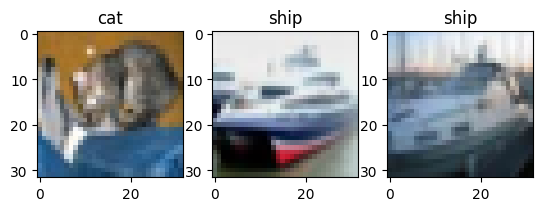

In [24]:
indexes_to_infer = [0, 1, 2]  # to plot specify indexes

plot_pictures(indexes_to_infer)

results_quanized = infer_on_images(compiled_model, indexes_to_infer)

print(f"Image labels using the quantized model : {results_quanized}.")